# <CENTER><div class="alert alert-block alert-info"><b> Segmentation des clients d'un site de e-commerce<br> Simulation dans le temps</b><div><CENTER>   
    

### Problématique:
- Comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs données personnelles.
- Fournir une segmentation des clients utilisable pour une campagne de communication par une entreprise proposant une solution de vente sur les marketplaces en ligne .
 

### Source du jeu de données:
https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

### Objectifs:
1. Faire une analyse exploratoire
2. Utiliser des méthodes non supervisées pour regrouper des clients de profils similaires .
3. Faire des simulations pour déterminer la fréquence nécessaire des mise à jours du modèle de segmentation (analyse de la stabilité des segments au cours du temps).(le présent notebook)
    
Pour ce dernier objectif, les variables doivent être recalculées en fonction de période de temps données

### <a name="C0">Sommaire</a>

- <a href="#C1">1. Importation des librairies nécessaires et mise en place du modle de vérification du format PEP8</a>
- <a href="#C2">2. Evolution dans le temps de l'indice de rand</a>
    - <a href="#C21">2.1. Préparation du jeu de données</a>
    - <a href="#C22">2.2. Définition d'une fonction permettant de créer les différents jeux de données nécessaires</a>
    - <a href="#C23">2.3. Clustering sur les différentes périodes de temps</a>

# <div class="alert alert-block alert-info"><a name="C1">1. Importation des librairies nécessaires et mise en place du module de vérification du format PEP8</a></div>

In [1]:
# Mise en place du module de vérification du format PEP8
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Importation des librairies nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import datetime

# Importation des librairies de Scikit-learn nécessaire
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import adjusted_rand_score

<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


# <div class="alert alert-block alert-info"><a name="C2">2. Evolution dans le temps de l'indice de rand</a></div>


## <div class="alert alert-block alert-info"><a name="C21">2.1. Préparation du jeu de données</a></div>

In [3]:
data = pd.read_csv("data_per_order.csv")
data.head()

,Unnamed: 0,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,order_id,order_status,...,number_of_review,mean_review_score,price_including_freight,freight_ratio,price_log,freight_value_log,payment_value_log,number_of_payment_type,delivery_delay,number_of_category
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.502070,-47.396822,00e7ee1b050b8499577073aeb2a297a1,delivered,...,1.0,4.0,146.87,14.897528,4.836203,3.130263,4.996334,1,19,1
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.727299,-46.542631,29150127e6685892b6eab3eec79f59c7,delivered,...,1.0,5.0,335.48,13.854775,5.669881,3.860309,5.818539,1,24,1
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.531294,-46.656404,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,...,1.0,5.0,157.73,11.278768,4.948334,2.933325,5.067205,1,24,1
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.497390,-46.182342,951670f92359f4fe4a63112aa7306eba,delivered,...,1.0,5.0,173.30,13.479515,5.016882,3.192942,5.160778,1,27,1
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.973309,-47.141530,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,...,1.0,5.0,252.25,8.820614,5.442418,3.146305,5.534377,1,16,1


**Changer le type de la variable "order_purchase_timestamp" au format datetime**

In [4]:
data["order_purchase_timestamp"] = (data["order_purchase_timestamp"]
                                    .astype("datetime64"))

**Connaitre la date la plus récente et la date la plus ancienne**

In [5]:
print("Date la plus ancienne =",
      data["order_purchase_timestamp"].min())
print("Date la plus récente =",
      data["order_purchase_timestamp"].max())

Date la plus ancienne = 2016-09-04 21:15:19
Date la plus récente = 2018-09-03 09:06:57


In [6]:
time_delta = int((data["order_purchase_timestamp"].max()
                  - data["order_purchase_timestamp"].min())
                 / np.timedelta64(1, "D"))
print("L'historique des commandes porte sur",
      time_delta,
      "jours")

L'historique des commandes porte sur 728 jours


<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>

## <div class="alert alert-block alert-info"><a name="C22">2.2. Définition d'une fonction permettant de créer les différents jeux de données nécessaires</a></div>

In [7]:
def make_dataset(data=data, initial=False, start_period=6, period=21):
    """start_period = nombre de mois sur lequel est fait la simulation.
       Si start_period=9, la simulation est faite sur les 9 derniers mois
       period= nombre de jours entre 2 simulations"""

    start_time = time.time()
    print("Création du jeu de données en cours")

    # Selection des commandes en fonction des périodes
    start = data["order_purchase_timestamp"].min()

    if (initial == True):
        stop = (data["order_purchase_timestamp"].max()
                - pd.DateOffset(months=start_period))
    else:
        stop = ((data["order_purchase_timestamp"].max()
                - pd.DateOffset(months=start_period))
                + (pd.DateOffset(days=period)))
        print("stop", stop)

    orders = data.loc[((data["order_purchase_timestamp"] >= start)
                       & (data["order_purchase_timestamp"] < stop))]

    date_start = orders["order_purchase_timestamp"].min()
    date_stop = orders["order_purchase_timestamp"].max()

    print("start", date_start)
    print("stop2", date_stop)

    # Détermination de la date la plus récente
    max_date = (max(orders["order_purchase_timestamp"])
                + datetime.timedelta(days=1))

    # Regroupement sur customer_unique_id
    data_new = orders.groupby("customer_unique_id")\
                     .agg({"customer_id": "count",
                           "order_purchase_timestamp": [(lambda x:
                                                         (max_date - x.max()).days),
                                                        "max"],
                           "delivery_delay": "mean",
                           "number_of_items": "sum",
                           "price_log": "sum",
                           "freight_value_log": "sum",
                           "payment_value_log": "mean",
                           "freight_ratio": "mean",
                           "number_of_payment_sequantial": "sum",
                           "mean_payment_installments": "mean",
                           "number_of_payment_type": "sum",
                           "number_of_category": "mean",
                           "number_of_review": "sum",
                           "mean_review_score": "mean"
                           }).reset_index()

    data_new.columns = ["customer_unique_id",
                        "number_of_order",
                        "number_of_days_since_last_order",
                        "order_purchase_timestamp",
                        "mean_delivery_delay",
                        "number_of_items",
                        "price_log",
                        "freight_value_log",
                        "mean_payment_log",
                        "mean_freight_ratio",
                        "number_of_payment_sequantial",
                        "mean_payment_installments",
                        "number_of_payment_type",
                        "number_of_category",
                        "number_of_review",
                        "mean_review_score"]

    data_new.drop(["customer_unique_id"], axis=1, inplace=True)

    # Remplissage des valeurs manquantes
    features_to_fill = data_new.isnull().sum()
    features_to_fill = features_to_fill[features_to_fill.values > 0].index.tolist()
    for f in features_to_fill:
        data_new[f] = data_new[f].fillna(data_new[f].mode()[0])

    return date_stop, data_new


<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>

## <div class="alert alert-block alert-info"><a name="C23">2.3. Clustering sur les différentes périodes de temps</a></div>

A présent, je vais tester différentes combinaisons de "start_period" (Nombre de mois sur lequel est réalisé la stimulation) et "period" (Nombre de jours séparant deux simulations)

In [8]:
# Définitions de "start_period" et "period"
start_period = [3, 6, 9, 12]
period = [7, 15, 21, 30]

Start_period = 3 mois
Création du jeu de données en cours
start 2016-09-04 21:15:19
stop2 2018-06-03 08:56:31
Nombre de jour entre le début de la simulation et la fin du jeu de données: 92 jours
period 7 jours
Création du jeu de données en cours
stop 2018-06-10 09:06:57
start 2016-09-04 21:15:19
stop2 2018-06-10 09:06:56
period 14 jours
Création du jeu de données en cours
stop 2018-06-17 09:06:57
start 2016-09-04 21:15:19
stop2 2018-06-17 09:01:36
period 21 jours
Création du jeu de données en cours
stop 2018-06-24 09:06:57
start 2016-09-04 21:15:19
stop2 2018-06-24 08:56:20
period 28 jours
Création du jeu de données en cours
stop 2018-07-01 09:06:57
start 2016-09-04 21:15:19
stop2 2018-07-01 09:05:17
period 35 jours
Création du jeu de données en cours
stop 2018-07-08 09:06:57
start 2016-09-04 21:15:19
stop2 2018-07-08 09:00:39
period 42 jours
Création du jeu de données en cours
stop 2018-07-15 09:06:57
start 2016-09-04 21:15:19
stop2 2018-07-15 08:33:19
period 49 jours
Création du jeu 

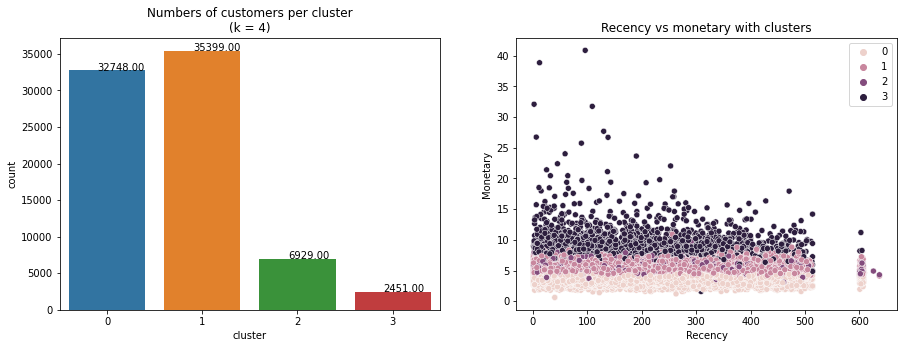

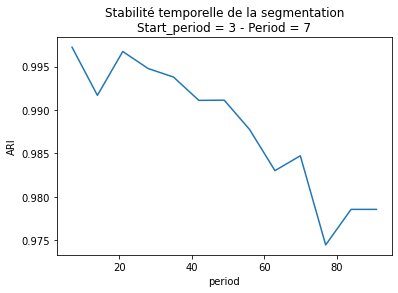

Start_period = 3 mois
Création du jeu de données en cours
start 2016-09-04 21:15:19
stop2 2018-06-03 08:56:31
Nombre de jour entre le début de la simulation et la fin du jeu de données: 92 jours
period 15 jours
Création du jeu de données en cours
stop 2018-06-18 09:06:57
start 2016-09-04 21:15:19
stop2 2018-06-18 08:59:45
period 30 jours
Création du jeu de données en cours
stop 2018-07-03 09:06:57
start 2016-09-04 21:15:19
stop2 2018-07-03 09:06:08
period 45 jours
Création du jeu de données en cours
stop 2018-07-18 09:06:57
start 2016-09-04 21:15:19
stop2 2018-07-18 09:03:04
period 60 jours
Création du jeu de données en cours
stop 2018-08-02 09:06:57
start 2016-09-04 21:15:19
stop2 2018-08-01 23:50:00
period 75 jours
Création du jeu de données en cours
stop 2018-08-17 09:06:57
start 2016-09-04 21:15:19
stop2 2018-08-17 09:01:51
period 90 jours
Création du jeu de données en cours
stop 2018-09-01 09:06:57
start 2016-09-04 21:15:19
stop2 2018-08-29 15:00:37


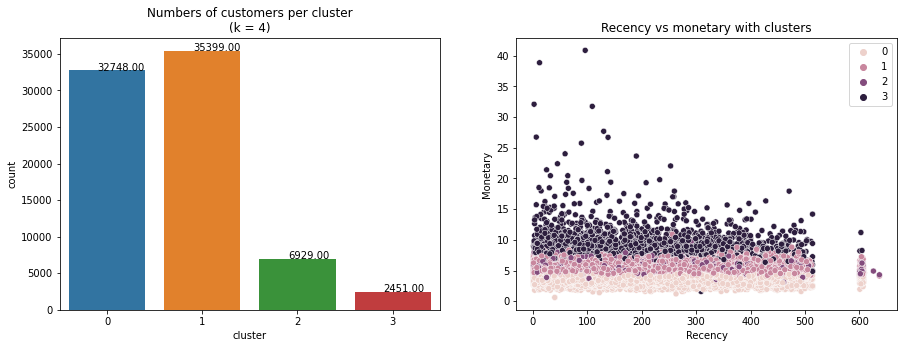

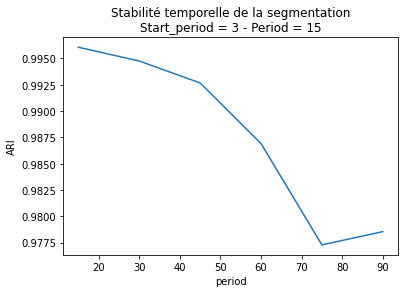

Start_period = 3 mois
Création du jeu de données en cours
start 2016-09-04 21:15:19
stop2 2018-06-03 08:56:31
Nombre de jour entre le début de la simulation et la fin du jeu de données: 92 jours
period 21 jours
Création du jeu de données en cours
stop 2018-06-24 09:06:57
start 2016-09-04 21:15:19
stop2 2018-06-24 08:56:20
period 42 jours
Création du jeu de données en cours
stop 2018-07-15 09:06:57
start 2016-09-04 21:15:19
stop2 2018-07-15 08:33:19
period 63 jours
Création du jeu de données en cours
stop 2018-08-05 09:06:57
start 2016-09-04 21:15:19
stop2 2018-08-05 08:53:21
period 84 jours
Création du jeu de données en cours
stop 2018-08-26 09:06:57
start 2016-09-04 21:15:19
stop2 2018-08-26 08:40:36


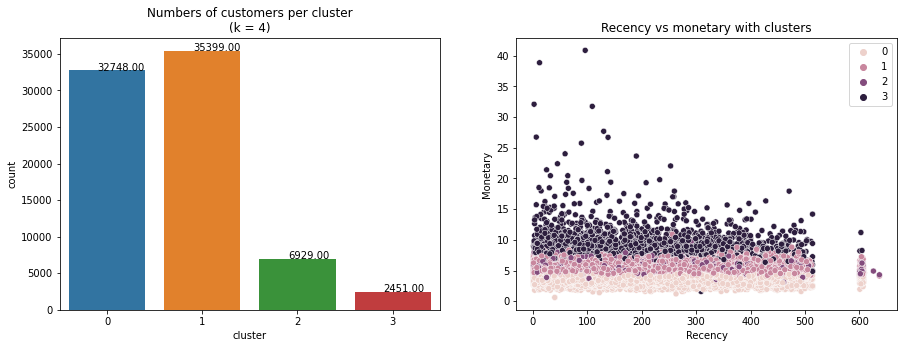

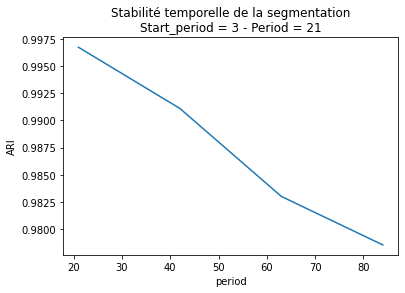

Start_period = 3 mois
Création du jeu de données en cours
start 2016-09-04 21:15:19
stop2 2018-06-03 08:56:31
Nombre de jour entre le début de la simulation et la fin du jeu de données: 92 jours
period 30 jours
Création du jeu de données en cours
stop 2018-07-03 09:06:57
start 2016-09-04 21:15:19
stop2 2018-07-03 09:06:08
period 60 jours
Création du jeu de données en cours
stop 2018-08-02 09:06:57
start 2016-09-04 21:15:19
stop2 2018-08-01 23:50:00
period 90 jours
Création du jeu de données en cours
stop 2018-09-01 09:06:57
start 2016-09-04 21:15:19
stop2 2018-08-29 15:00:37


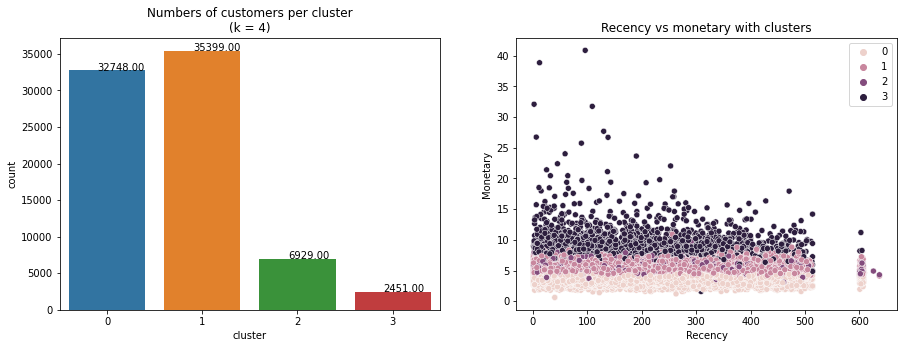

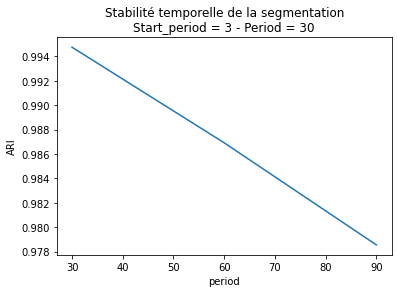

Start_period = 6 mois
Création du jeu de données en cours
start 2016-09-04 21:15:19
stop2 2018-03-03 09:01:00
Nombre de jour entre le début de la simulation et la fin du jeu de données: 184 jours
period 7 jours
Création du jeu de données en cours
stop 2018-03-10 09:06:57
start 2016-09-04 21:15:19
stop2 2018-03-10 08:55:54
period 14 jours
Création du jeu de données en cours
stop 2018-03-17 09:06:57
start 2016-09-04 21:15:19
stop2 2018-03-17 08:56:12
period 21 jours
Création du jeu de données en cours
stop 2018-03-24 09:06:57
start 2016-09-04 21:15:19
stop2 2018-03-24 08:50:04
period 28 jours
Création du jeu de données en cours
stop 2018-03-31 09:06:57
start 2016-09-04 21:15:19
stop2 2018-03-31 09:01:18
period 35 jours
Création du jeu de données en cours
stop 2018-04-07 09:06:57
start 2016-09-04 21:15:19
stop2 2018-04-07 08:45:54
period 42 jours
Création du jeu de données en cours
stop 2018-04-14 09:06:57
start 2016-09-04 21:15:19
stop2 2018-04-14 08:49:33
period 49 jours
Création du jeu

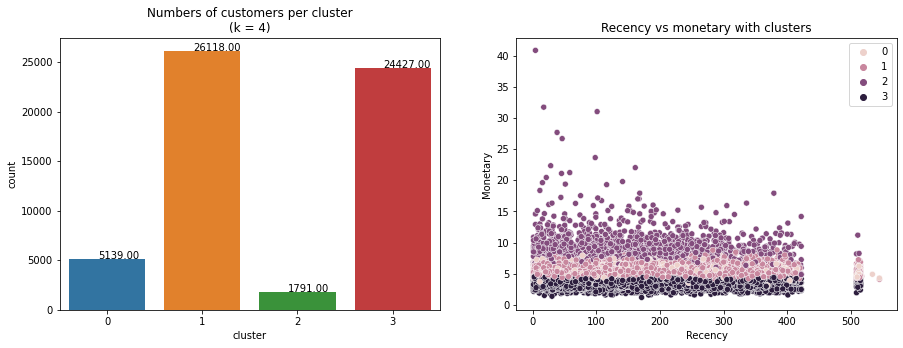

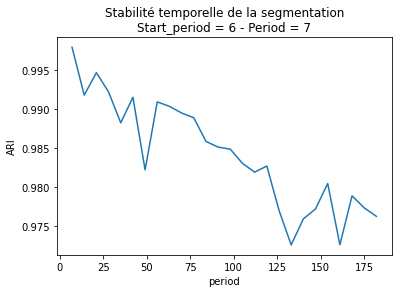

Start_period = 6 mois
Création du jeu de données en cours
start 2016-09-04 21:15:19
stop2 2018-03-03 09:01:00
Nombre de jour entre le début de la simulation et la fin du jeu de données: 184 jours
period 15 jours
Création du jeu de données en cours
stop 2018-03-18 09:06:57
start 2016-09-04 21:15:19
stop2 2018-03-18 08:54:39
period 30 jours
Création du jeu de données en cours
stop 2018-04-02 09:06:57
start 2016-09-04 21:15:19
stop2 2018-04-02 09:01:04
period 45 jours
Création du jeu de données en cours
stop 2018-04-17 09:06:57
start 2016-09-04 21:15:19
stop2 2018-04-17 09:05:11
period 60 jours
Création du jeu de données en cours
stop 2018-05-02 09:06:57
start 2016-09-04 21:15:19
stop2 2018-05-02 09:04:43
period 75 jours
Création du jeu de données en cours
stop 2018-05-17 09:06:57
start 2016-09-04 21:15:19
stop2 2018-05-17 09:06:35
period 90 jours
Création du jeu de données en cours
stop 2018-06-01 09:06:57
start 2016-09-04 21:15:19
stop2 2018-06-01 08:56:59
period 105 jours
Création du j

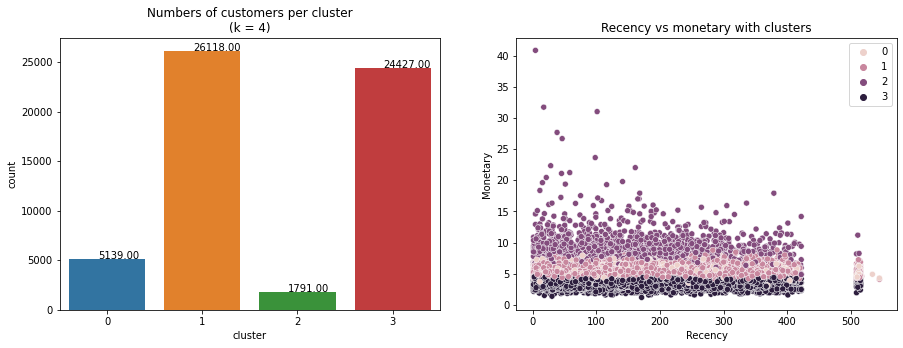

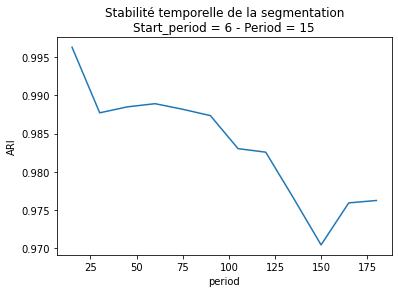

Start_period = 6 mois
Création du jeu de données en cours
start 2016-09-04 21:15:19
stop2 2018-03-03 09:01:00
Nombre de jour entre le début de la simulation et la fin du jeu de données: 184 jours
period 21 jours
Création du jeu de données en cours
stop 2018-03-24 09:06:57
start 2016-09-04 21:15:19
stop2 2018-03-24 08:50:04
period 42 jours
Création du jeu de données en cours
stop 2018-04-14 09:06:57
start 2016-09-04 21:15:19
stop2 2018-04-14 08:49:33
period 63 jours
Création du jeu de données en cours
stop 2018-05-05 09:06:57
start 2016-09-04 21:15:19
stop2 2018-05-05 08:56:58
period 84 jours
Création du jeu de données en cours
stop 2018-05-26 09:06:57
start 2016-09-04 21:15:19
stop2 2018-05-26 08:58:34
period 105 jours
Création du jeu de données en cours
stop 2018-06-16 09:06:57
start 2016-09-04 21:15:19
stop2 2018-06-16 08:42:28
period 126 jours
Création du jeu de données en cours
stop 2018-07-07 09:06:57
start 2016-09-04 21:15:19
stop2 2018-07-07 09:02:51
period 147 jours
Création du

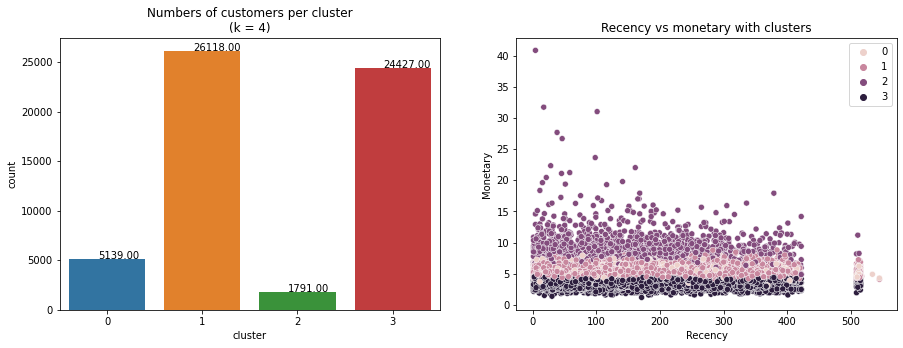

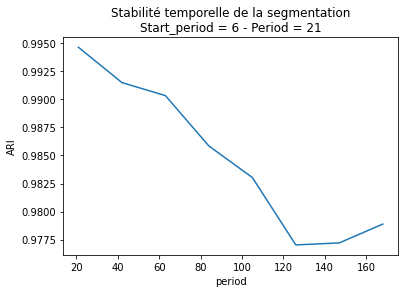

Start_period = 6 mois
Création du jeu de données en cours
start 2016-09-04 21:15:19
stop2 2018-03-03 09:01:00
Nombre de jour entre le début de la simulation et la fin du jeu de données: 184 jours
period 30 jours
Création du jeu de données en cours
stop 2018-04-02 09:06:57
start 2016-09-04 21:15:19
stop2 2018-04-02 09:01:04
period 60 jours
Création du jeu de données en cours
stop 2018-05-02 09:06:57
start 2016-09-04 21:15:19
stop2 2018-05-02 09:04:43
period 90 jours
Création du jeu de données en cours
stop 2018-06-01 09:06:57
start 2016-09-04 21:15:19
stop2 2018-06-01 08:56:59
period 120 jours
Création du jeu de données en cours
stop 2018-07-01 09:06:57
start 2016-09-04 21:15:19
stop2 2018-07-01 09:05:17
period 150 jours
Création du jeu de données en cours
stop 2018-07-31 09:06:57
start 2016-09-04 21:15:19
stop2 2018-07-31 08:57:40
period 180 jours
Création du jeu de données en cours
stop 2018-08-30 09:06:57
start 2016-09-04 21:15:19
stop2 2018-08-29 15:00:37


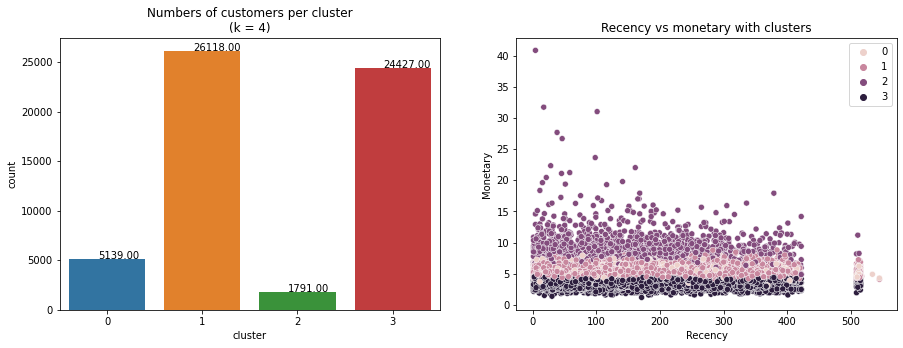

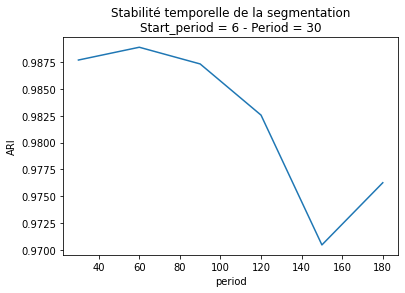

Start_period = 9 mois
Création du jeu de données en cours
start 2016-09-04 21:15:19
stop2 2017-12-03 08:36:17
Nombre de jour entre le début de la simulation et la fin du jeu de données: 274 jours
period 7 jours
Création du jeu de données en cours
stop 2017-12-10 09:06:57
start 2016-09-04 21:15:19
stop2 2017-12-10 08:58:19
period 14 jours
Création du jeu de données en cours
stop 2017-12-17 09:06:57
start 2016-09-04 21:15:19
stop2 2017-12-17 08:26:41
period 21 jours
Création du jeu de données en cours
stop 2017-12-24 09:06:57
start 2016-09-04 21:15:19
stop2 2017-12-24 08:21:30
period 28 jours
Création du jeu de données en cours
stop 2017-12-31 09:06:57
start 2016-09-04 21:15:19
stop2 2017-12-31 09:06:19
period 35 jours
Création du jeu de données en cours
stop 2018-01-07 09:06:57
start 2016-09-04 21:15:19
stop2 2018-01-07 08:53:53
period 42 jours
Création du jeu de données en cours
stop 2018-01-14 09:06:57
start 2016-09-04 21:15:19
stop2 2018-01-14 09:06:06
period 49 jours
Création du jeu

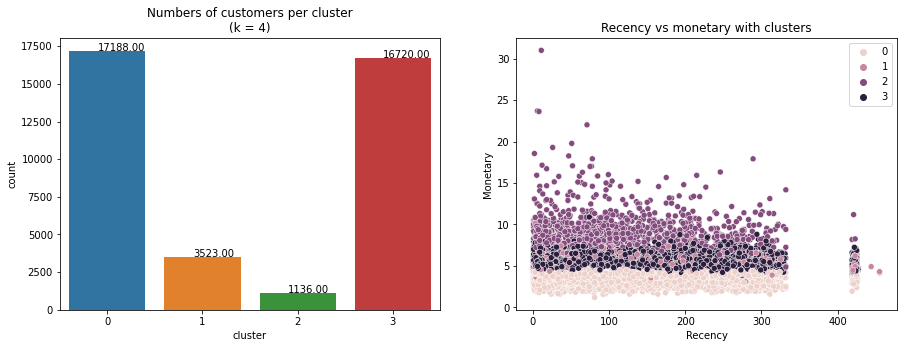

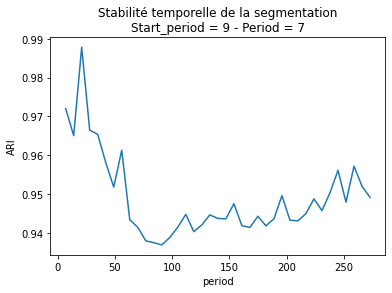

Start_period = 9 mois
Création du jeu de données en cours
start 2016-09-04 21:15:19
stop2 2017-12-03 08:36:17
Nombre de jour entre le début de la simulation et la fin du jeu de données: 274 jours
period 15 jours
Création du jeu de données en cours
stop 2017-12-18 09:06:57
start 2016-09-04 21:15:19
stop2 2017-12-18 09:05:02
period 30 jours
Création du jeu de données en cours
stop 2018-01-02 09:06:57
start 2016-09-04 21:15:19
stop2 2018-01-02 08:33:33
period 45 jours
Création du jeu de données en cours
stop 2018-01-17 09:06:57
start 2016-09-04 21:15:19
stop2 2018-01-17 08:56:52
period 60 jours
Création du jeu de données en cours
stop 2018-02-01 09:06:57
start 2016-09-04 21:15:19
stop2 2018-02-01 09:05:50
period 75 jours
Création du jeu de données en cours
stop 2018-02-16 09:06:57
start 2016-09-04 21:15:19
stop2 2018-02-16 09:01:38
period 90 jours
Création du jeu de données en cours
stop 2018-03-03 09:06:57
start 2016-09-04 21:15:19
stop2 2018-03-03 09:01:00
period 105 jours
Création du j

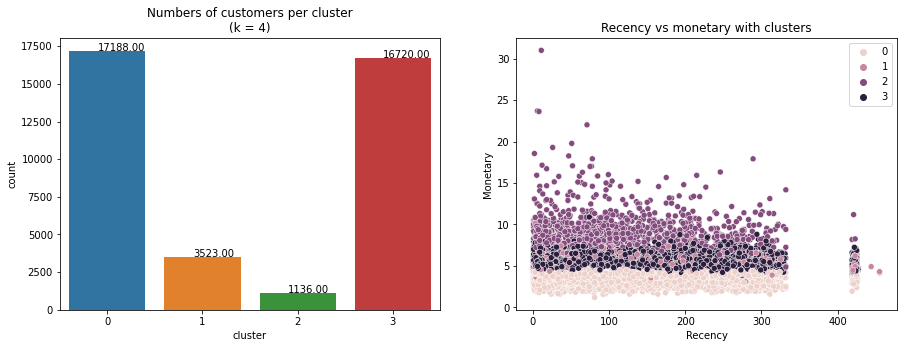

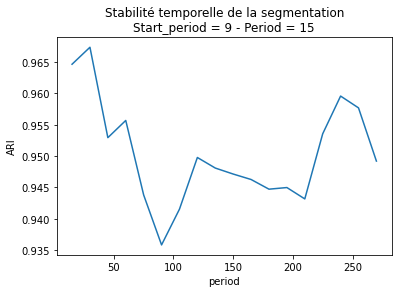

Start_period = 9 mois
Création du jeu de données en cours
start 2016-09-04 21:15:19
stop2 2017-12-03 08:36:17
Nombre de jour entre le début de la simulation et la fin du jeu de données: 274 jours
period 21 jours
Création du jeu de données en cours
stop 2017-12-24 09:06:57
start 2016-09-04 21:15:19
stop2 2017-12-24 08:21:30
period 42 jours
Création du jeu de données en cours
stop 2018-01-14 09:06:57
start 2016-09-04 21:15:19
stop2 2018-01-14 09:06:06
period 63 jours
Création du jeu de données en cours
stop 2018-02-04 09:06:57
start 2016-09-04 21:15:19
stop2 2018-02-04 08:59:46
period 84 jours
Création du jeu de données en cours
stop 2018-02-25 09:06:57
start 2016-09-04 21:15:19
stop2 2018-02-25 09:05:13
period 105 jours
Création du jeu de données en cours
stop 2018-03-18 09:06:57
start 2016-09-04 21:15:19
stop2 2018-03-18 08:54:39
period 126 jours
Création du jeu de données en cours
stop 2018-04-08 09:06:57
start 2016-09-04 21:15:19
stop2 2018-04-08 08:59:35
period 147 jours
Création du

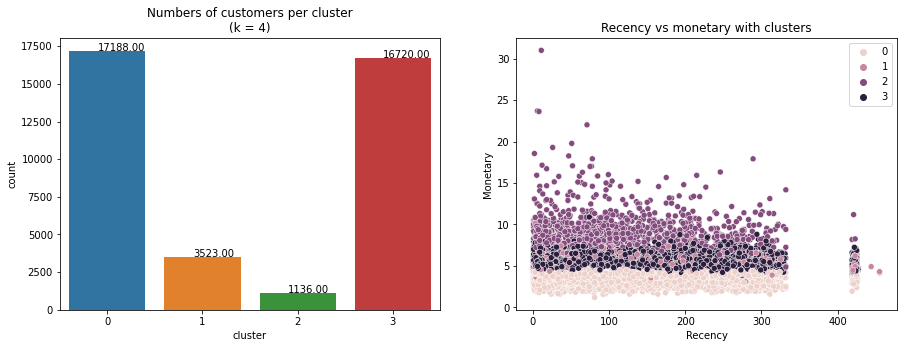

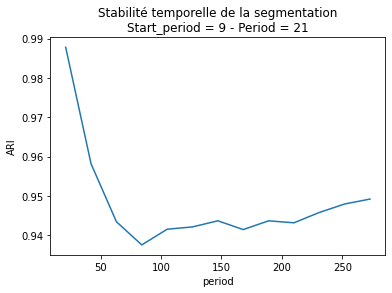

Start_period = 9 mois
Création du jeu de données en cours
start 2016-09-04 21:15:19
stop2 2017-12-03 08:36:17
Nombre de jour entre le début de la simulation et la fin du jeu de données: 274 jours
period 30 jours
Création du jeu de données en cours
stop 2018-01-02 09:06:57
start 2016-09-04 21:15:19
stop2 2018-01-02 08:33:33
period 60 jours
Création du jeu de données en cours
stop 2018-02-01 09:06:57
start 2016-09-04 21:15:19
stop2 2018-02-01 09:05:50
period 90 jours
Création du jeu de données en cours
stop 2018-03-03 09:06:57
start 2016-09-04 21:15:19
stop2 2018-03-03 09:01:00
period 120 jours
Création du jeu de données en cours
stop 2018-04-02 09:06:57
start 2016-09-04 21:15:19
stop2 2018-04-02 09:01:04
period 150 jours
Création du jeu de données en cours
stop 2018-05-02 09:06:57
start 2016-09-04 21:15:19
stop2 2018-05-02 09:04:43
period 180 jours
Création du jeu de données en cours
stop 2018-06-01 09:06:57
start 2016-09-04 21:15:19
stop2 2018-06-01 08:56:59
period 210 jours
Création d

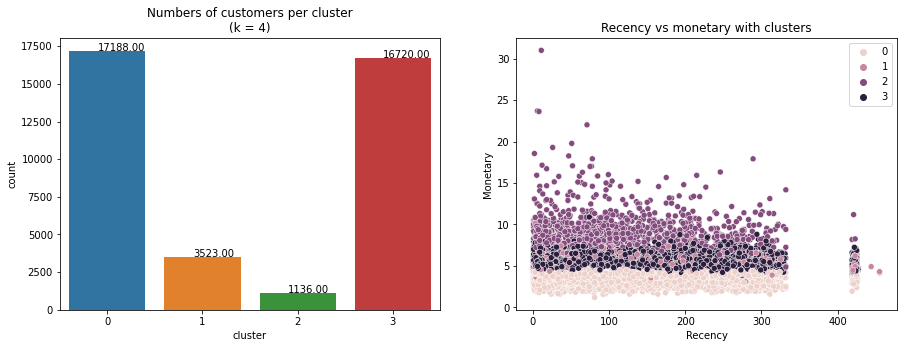

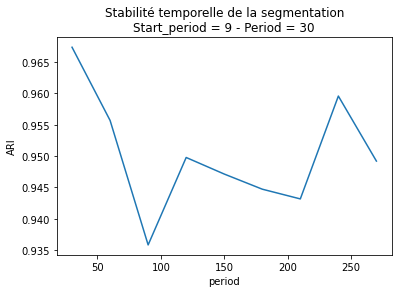

Start_period = 12 mois
Création du jeu de données en cours
start 2016-09-04 21:15:19
stop2 2017-09-03 08:38:24
Nombre de jour entre le début de la simulation et la fin du jeu de données: 365 jours
period 7 jours
Création du jeu de données en cours
stop 2017-09-10 09:06:57
start 2016-09-04 21:15:19
stop2 2017-09-10 08:56:41
period 14 jours
Création du jeu de données en cours
stop 2017-09-17 09:06:57
start 2016-09-04 21:15:19
stop2 2017-09-17 09:04:46
period 21 jours
Création du jeu de données en cours
stop 2017-09-24 09:06:57
start 2016-09-04 21:15:19
stop2 2017-09-24 08:53:40
period 28 jours
Création du jeu de données en cours
stop 2017-10-01 09:06:57
start 2016-09-04 21:15:19
stop2 2017-10-01 08:57:03
period 35 jours
Création du jeu de données en cours
stop 2017-10-08 09:06:57
start 2016-09-04 21:15:19
stop2 2017-10-08 09:00:30
period 42 jours
Création du jeu de données en cours
stop 2017-10-15 09:06:57
start 2016-09-04 21:15:19
stop2 2017-10-15 09:05:49
period 49 jours
Création du je

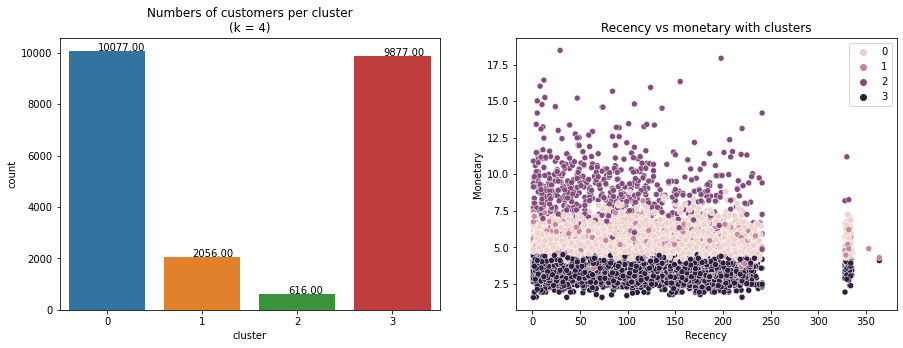

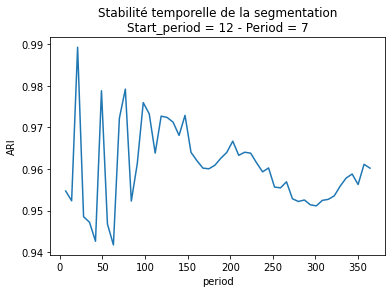

Start_period = 12 mois
Création du jeu de données en cours
start 2016-09-04 21:15:19
stop2 2017-09-03 08:38:24
Nombre de jour entre le début de la simulation et la fin du jeu de données: 365 jours
period 15 jours
Création du jeu de données en cours
stop 2017-09-18 09:06:57
start 2016-09-04 21:15:19
stop2 2017-09-18 09:02:16
period 30 jours
Création du jeu de données en cours
stop 2017-10-03 09:06:57
start 2016-09-04 21:15:19
stop2 2017-10-03 08:48:54
period 45 jours
Création du jeu de données en cours
stop 2017-10-18 09:06:57
start 2016-09-04 21:15:19
stop2 2017-10-18 09:01:31
period 60 jours
Création du jeu de données en cours
stop 2017-11-02 09:06:57
start 2016-09-04 21:15:19
stop2 2017-11-02 08:19:51
period 75 jours
Création du jeu de données en cours
stop 2017-11-17 09:06:57
start 2016-09-04 21:15:19
stop2 2017-11-17 08:56:41
period 90 jours
Création du jeu de données en cours
stop 2017-12-02 09:06:57
start 2016-09-04 21:15:19
stop2 2017-12-02 09:06:33
period 105 jours
Création du 

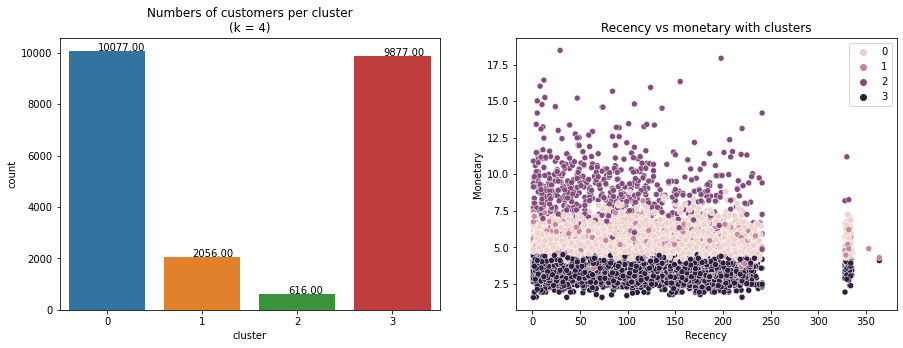

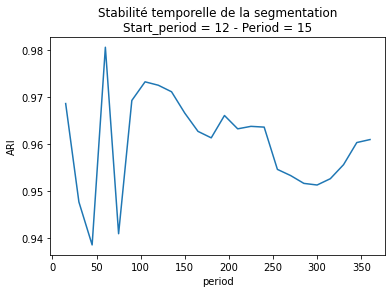

Start_period = 12 mois
Création du jeu de données en cours
start 2016-09-04 21:15:19
stop2 2017-09-03 08:38:24
Nombre de jour entre le début de la simulation et la fin du jeu de données: 365 jours
period 21 jours
Création du jeu de données en cours
stop 2017-09-24 09:06:57
start 2016-09-04 21:15:19
stop2 2017-09-24 08:53:40
period 42 jours
Création du jeu de données en cours
stop 2017-10-15 09:06:57
start 2016-09-04 21:15:19
stop2 2017-10-15 09:05:49
period 63 jours
Création du jeu de données en cours
stop 2017-11-05 09:06:57
start 2016-09-04 21:15:19
stop2 2017-11-05 08:20:03
period 84 jours
Création du jeu de données en cours
stop 2017-11-26 09:06:57
start 2016-09-04 21:15:19
stop2 2017-11-26 08:55:43
period 105 jours
Création du jeu de données en cours
stop 2017-12-17 09:06:57
start 2016-09-04 21:15:19
stop2 2017-12-17 08:26:41
period 126 jours
Création du jeu de données en cours
stop 2018-01-07 09:06:57
start 2016-09-04 21:15:19
stop2 2018-01-07 08:53:53
period 147 jours
Création d

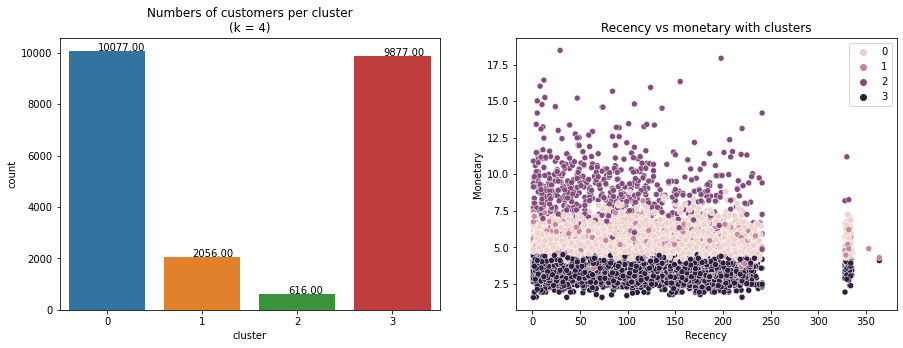

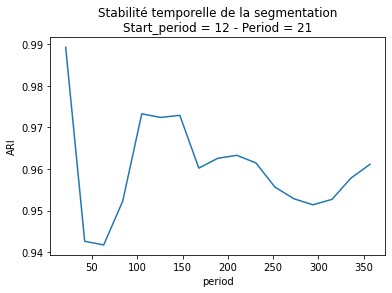

Start_period = 12 mois
Création du jeu de données en cours
start 2016-09-04 21:15:19
stop2 2017-09-03 08:38:24
Nombre de jour entre le début de la simulation et la fin du jeu de données: 365 jours
period 30 jours
Création du jeu de données en cours
stop 2017-10-03 09:06:57
start 2016-09-04 21:15:19
stop2 2017-10-03 08:48:54
period 60 jours
Création du jeu de données en cours
stop 2017-11-02 09:06:57
start 2016-09-04 21:15:19
stop2 2017-11-02 08:19:51
period 90 jours
Création du jeu de données en cours
stop 2017-12-02 09:06:57
start 2016-09-04 21:15:19
stop2 2017-12-02 09:06:33
period 120 jours
Création du jeu de données en cours
stop 2018-01-01 09:06:57
start 2016-09-04 21:15:19
stop2 2018-01-01 08:45:04
period 150 jours
Création du jeu de données en cours
stop 2018-01-31 09:06:57
start 2016-09-04 21:15:19
stop2 2018-01-31 08:57:43
period 180 jours
Création du jeu de données en cours
stop 2018-03-02 09:06:57
start 2016-09-04 21:15:19
stop2 2018-03-02 08:56:47
period 210 jours
Création 

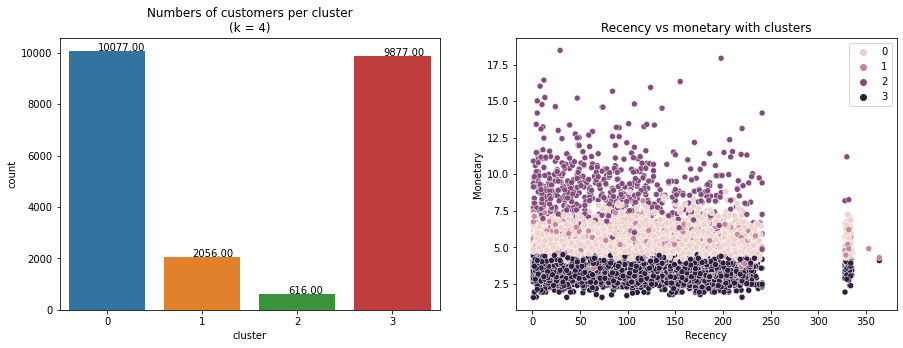

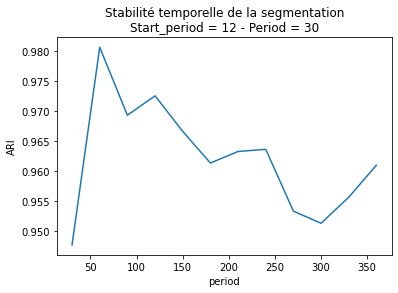

In [9]:
# Boucle pour réaliser la simulation pour les différentes combinaisons
for sp in start_period:
    for days in period:
        print("Start_period =", sp, "mois")

        # Creation du jeu de données pour le KMeans initial
        date_stop, data_t0 = make_dataset(data=data,
                                          initial=True,
                                          start_period=sp,
                                          period=days)
        
        data_t0K = data_t0.drop(["order_purchase_timestamp"], axis=1)

        # KMeans initial
        kmeans_t0 = Pipeline([("preprocessor", StandardScaler()),
                              ("kmeans", KMeans(n_clusters=4, init="k-means++", n_init=10, random_state=42))])
        kmeans_t0.fit(data_t0K)
        t0_labels = kmeans_t0.predict(data_t0K)
                
        # Représentation graphique du clustering initial
        data_t0K["cluster"] = t0_labels
        fig = plt.figure(figsize=(15, 5))
        ax1 = plt.subplot(1, 2, 1)
        ax1 = sns.countplot(data=data_t0K, x='cluster')
        for p in ax1.patches:
            ax1.annotate("{:.2f}".format(p.get_height()),
                        (p.get_x() + 0.3,
                         p.get_height() + 1))
        ax1.set_title("Numbers of customers per cluster""\n"
                      "(k = {k})".format(k=4))

        ax2 = plt.subplot(1, 2, 2)
        ax2 = sns.scatterplot(data=data_t0K,
                              x="number_of_days_since_last_order",
                              y="price_log",
                              hue=t0_labels)
        ax2.set_title("Recency vs monetary with clusters")
        ax2.set_xlabel("Recency")
        ax2.set_ylabel("Monetary")

        # Détermination du nombre de jour entre 
        # le début de la pérriode de simulation et la fin
        time_delta = (data["order_purchase_timestamp"].max() 
                      - data_t0["order_purchase_timestamp"].max())
        time_delta= time_delta.days
        print("Nombre de jour entre le début de la simulation",
              "et la fin du jeu de données:", 
              time_delta,
              "jours")

        ari_score = []
        increment_days = days

        for d in np.arange(days, time_delta, days):
            print("period", d, "jours")

            # Création d'un jeu de données pour la période
            date_stop, data_tx = make_dataset(data=data,
                                              initial=False,
                                              start_period=sp,
                                              period=np.float64(d))
            
            data_tx.drop(["order_purchase_timestamp"],
                         axis=1,
                         inplace=True)
    
            kmeans_tx = Pipeline([("preprocessor", StandardScaler()),
                                  ("kmeans", KMeans(n_clusters=4, init="k-means++", n_init=10, random_state=42))])
            kmeans_tx.fit(data_tx)
            tx_labels = kmeans_tx.predict(data_tx)

            tx_labels_t0 = kmeans_t0.predict(data_tx)

            # Calcul du score ARI
            ari_p = adjusted_rand_score(tx_labels_t0, tx_labels)
            ari_score.append([d, ari_p])

            increment_days += d

        df_ari = pd.DataFrame(ari_score, columns=["period", "ARI"])

        fig2 = plt.figure()
        ax = sns.lineplot(data=df_ari,
                          x="period",
                          y="ARI")
        ax.set_title("Stabilité temporelle de la segmentation""\n"
                    "Start_period = {sp} - Period = {p}".format(sp=sp, p=days))

        plt.show()